Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
288 matching events found
No baseline correction applied
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
288 matching events found
No baseline correction applied
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata wi

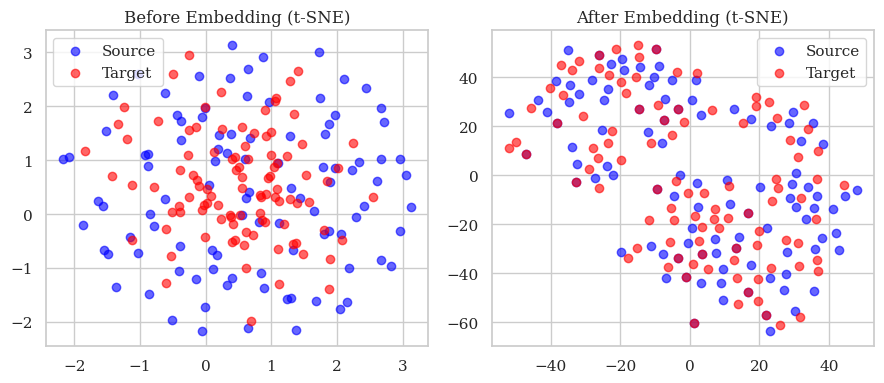

In [5]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import mne
from moabb.datasets import BNCI2014_001
from moabb.paradigms import LeftRightImagery

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

##############################################################################
# SETUP DATA AND PARADIGM
##############################################################################

# We use BNCI2014_001, corresponding to BCI Competition IV 2a.
# The relevant classes for LeftRightImagery are left vs right hand motor imagery.
dataset = BNCI2014_001()
paradigm = LeftRightImagery()

# Optionally, you could limit the subjects for faster testing:
# dataset.subject_list = [1, 2]

subject_list = [1,2]

##############################################################################
# REUSABLE FUNCTIONS (SIMPLIFIED VERSIONS OF THE PAPER'S STEPS)
##############################################################################
from sklearn.covariance import EmpiricalCovariance
from scipy.linalg import logm, sqrtm, expm
import copy

def riemannian_mean(list_of_covs):
    """
    Simplified iterative Riemannian mean for SPD matrices.
    """
    n_mats = len(list_of_covs)
    M = np.mean(list_of_covs, axis=0)
    for _ in range(5):
        Msqrt = sqrtm(M)
        Minvsqrt = np.linalg.inv(Msqrt)
        s = np.zeros_like(M)
        for c in list_of_covs:
            tmp = logm(Minvsqrt @ c @ Minvsqrt)
            s += tmp
        s /= n_mats
        M = Msqrt @ expm(s) @ Msqrt
    return M

def project_to_tangent_space(cov, ref):
    ref_inv_sqrt = np.linalg.inv(sqrtm(ref))
    aligned = ref_inv_sqrt @ cov @ ref_inv_sqrt
    return sym_matrix_to_vector(logm(aligned))

def sym_matrix_to_vector(mat):
    idx = np.triu_indices_from(mat)
    return mat[idx].real

def transform_source_via_optimal_transport(source_X, target_X, reg=1e-3):
    """
    Simplified "optimal transport" style alignment via
    a linear assignment solution of minimal squared distance.
    """
    from scipy.optimize import linear_sum_assignment
    cost = np.sum((source_X[:, None, :] - target_X[None, :, :])**2, axis=2)
    row_ind, col_ind = linear_sum_assignment(cost)
    new_source = np.copy(source_X)
    for i, j in zip(row_ind, col_ind):
        new_source[i] = target_X[j]
    return new_source

def subspace_mapping_kernel(source_X, target_X, dim=5):
    """
    Very simplified subspace alignment: we do PCA on the
    combined data to map them to a shared subspace.
    """
    from sklearn.decomposition import PCA
    stacked = np.vstack((source_X, target_X))
    pca = PCA(n_components=dim)
    mapped = pca.fit_transform(stacked)
    ns = len(source_X)
    s_mapped = mapped[:ns]
    t_mapped = mapped[ns:]
    return s_mapped, t_mapped

def three_stage_transfer_learning(X_src, y_src, X_tgt, n_ch, n_dim=5):
    """
    Simplifies the 3-stage approach:
     1) Riemann Tangent Space Mapping
     2) Optimal Transport on source
     3) Subspace mapping
    """
    all_cov_src = []
    for xi in X_src:
        cov = EmpiricalCovariance().fit(xi.T).covariance_
        all_cov_src.append(cov)

    all_cov_tgt = []
    for xi in X_tgt:
        cov = EmpiricalCovariance().fit(xi.T).covariance_
        all_cov_tgt.append(cov)

    # Single reference from combined domain
    all_covs = np.array(all_cov_src + all_cov_tgt)
    M = riemannian_mean(all_covs)

    # tangent space
    t_src = np.array([project_to_tangent_space(c, M) for c in all_cov_src])
    t_tgt = np.array([project_to_tangent_space(c, M) for c in all_cov_tgt])

    # OT transform of source
    t_src_aligned = transform_source_via_optimal_transport(t_src, t_tgt)

    # subspace
    s_map, t_map = subspace_mapping_kernel(t_src_aligned, t_tgt, dim=n_dim)
    return s_map, y_src, t_map

##############################################################################
# MANUAL CROSS-SUBJECT EVALUATION
##############################################################################
# We will iterate over each subject as the test (target) domain,
# and train on all other subjects (source) domain[2].
perf_scores = []
src_embeddings_before = []
tgt_embeddings_before = []
src_embeddings_after = []
tgt_embeddings_after = []
src_labels_collected = []
tgt_labels_collected = []

for test_subject in subject_list:
    # Train subjects are all the others
    train_subjects = [s for s in subject_list if s != test_subject]

    # Retrieve train data
    X_train, y_train, meta_train = paradigm.get_data(
        dataset=dataset, subjects=train_subjects, return_epochs=True
    )
    # Retrieve test data
    X_test, y_test, meta_test = paradigm.get_data(
        dataset=dataset, subjects=[test_subject], return_epochs=True
    )

    # Flatten (before) for visualization
    flat_train = np.array([ep.flatten() for ep in X_train.get_data()])
    flat_test  = np.array([ep.flatten() for ep in X_test.get_data()])

    src_embeddings_before.append(flat_train)
    tgt_embeddings_before.append(flat_test)
    src_labels_collected.append(y_train)
    tgt_labels_collected.append(y_test)

    # Convert EEG epochs to numpy (n_trials, n_channels, n_times)
    X_train_data = X_train.get_data()
    X_test_data = X_test.get_data()

    # apply 3-stage TSTL
    s_mapped, y_s, t_mapped = three_stage_transfer_learning(
        X_train_data, y_train, X_test_data, n_ch=X_train_data.shape[1], n_dim=10
    )
    src_embeddings_after.append(s_mapped)
    tgt_embeddings_after.append(t_mapped)

    # Classification
    clf = LDA()
    clf.fit(s_mapped, y_s)
    y_pred = clf.predict(t_mapped)
    score = accuracy_score(y_test, y_pred)
    perf_scores.append(score)

mean_score = np.mean(perf_scores)
std_score = np.std(perf_scores)
print("Cross-subject average classification accuracy: {:.2f}% (+/- {:.2f}%)"
      .format(mean_score*100, std_score*100))

##############################################################################
# OPTIONAL: VISUALIZE EMBEDDINGS VIA T-SNE ON FIRST FOLD
##############################################################################

if len(src_embeddings_before) > 0:
    fold_idx = 0
    Xb_src = src_embeddings_before[fold_idx]
    Xb_tgt = tgt_embeddings_before[fold_idx]
    yb_src = src_labels_collected[fold_idx]
    yb_tgt = tgt_labels_collected[fold_idx]

    Xa_src = src_embeddings_after[fold_idx]
    Xa_tgt = tgt_embeddings_after[fold_idx]

    # pick subset for TSNE
    ns_src = len(Xb_src)
    ns_tgt = len(Xb_tgt)
    sub_idx_src = np.random.choice(ns_src, size=min(ns_src,100), replace=False)
    sub_idx_tgt = np.random.choice(ns_tgt, size=min(ns_tgt,100), replace=False)

    Xb_concat = np.vstack((Xb_src[sub_idx_src], Xb_tgt[sub_idx_tgt]))
    dom_concat = np.array([0]*len(sub_idx_src) + [1]*len(sub_idx_tgt))

    tsne_before = TSNE(n_components=2, random_state=42)
    emb_before = tsne_before.fit_transform(Xb_concat)

    plt.figure(figsize=(9,4))
    plt.subplot(1,2,1)
    plt.title("Before Embedding (t-SNE)")
    plt.scatter(emb_before[dom_concat==0,0], emb_before[dom_concat==0,1], 
                c='blue', alpha=0.6, label='Source')
    plt.scatter(emb_before[dom_concat==1,0], emb_before[dom_concat==1,1], 
                c='red', alpha=0.6, label='Target')
    plt.legend()

    # After
    Xa_concat = np.vstack((Xa_src[sub_idx_src], Xa_tgt[sub_idx_tgt]))
    dom_concat_a = np.array([0]*len(sub_idx_src) + [1]*len(sub_idx_tgt))

    tsne_after = TSNE(n_components=2, random_state=42)
    emb_after = tsne_after.fit_transform(Xa_concat)

    plt.subplot(1,2,2)
    plt.title("After Embedding (t-SNE)")
    plt.scatter(emb_after[dom_concat_a==0,0], emb_after[dom_concat_a==0,1], 
                c='blue', alpha=0.6, label='Source')
    plt.scatter(emb_after[dom_concat_a==1,0], emb_after[dom_concat_a==1,1], 
                c='red', alpha=0.6, label='Target')
    plt.legend()
    plt.tight_layout()
    plt.show()
